# Per-Period Confidence Intervals for Synthetic Control

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Appendix A1 | Notebook 2 of 2**

This notebook extends conformal inference to construct per-period
confidence intervals for treatment effects, applied to the
Proposition 99 (California cigarette) case study.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

---

## 1. Intuition {#intuition}

### From P-Values to Confidence Intervals

**Previous notebook**: Conformal p-value tests $H_0: \theta = 0$.

**This notebook**: Construct confidence intervals by inverting the test.

**Core idea**:
$$CI_{1-\alpha} = \{\theta^0 : \text{p-value}(\theta^0) > \alpha\}$$

The confidence interval contains all hypothesized values that we 
*cannot reject* at level α.

### Per-Period vs Aggregate Effects

**Aggregate CI** (what p-value gives):
- Tests joint null: $H_0: \theta_t = 0 \ \forall t > T_0$
- Single p-value for entire post-treatment period

**Per-period CI** (more informative):
- Separate CI for each post-treatment period
- Shows how effect evolves over time
- More useful for policy analysis

```
★ Insight ─────────────────────────────────────────────────────
Per-period CIs answer: "At each time point, what range of 
treatment effects is consistent with the data?"

This is more informative than a single aggregate p-value,
especially when effects evolve over time.
──────────────────────────────────────────────────────────────
```

---

## 2. Formal Treatment {#formal}

### 2.1 Per-Period Null Hypothesis

For each post-treatment period $t > T_0$:

$$H_{0,t}: \theta_{1t} = \theta^0_t$$

**Adjusted outcome** under this null:
$$\tilde{Y}_{1t} = Y_{1t} - \theta^0_t$$

### 2.2 Per-Period Test Statistic

For period $t$, focus on single-period residual:

$$S_t(\theta^0_t) = |\tilde{Y}_{1t} - \hat{Y}^{SC}_{1t}| = |Y_{1t} - \theta^0_t - \hat{Y}^{SC}_{1t}|$$

**Placebo statistics**: For each control unit $j$:
$$S_{j,t} = |Y_{jt} - \hat{Y}^{SC,(-1)}_{jt}|$$

where $\hat{Y}^{SC,(-1)}_{jt}$ is synthetic control for unit $j$ using all 
units except the original treated unit.

### 2.3 Per-Period P-Value

$$p_t(\theta^0_t) = \frac{1}{J+1} \sum_{j=1}^{J+1} \mathbf{1}\{S_{j,t} \geq S_t(\theta^0_t)\}$$

### 2.4 Per-Period Confidence Interval

**Inversion approach**:

$$CI_t(\alpha) = \{\theta^0_t : p_t(\theta^0_t) > \alpha\}$$

**Practical computation** (grid search):

1. Grid of candidate values: $\theta^0_t \in [\theta_{min}, \theta_{max}]$
2. For each $\theta^0_t$, compute $p_t(\theta^0_t)$
3. CI bounds = extreme $\theta^0_t$ with $p_t > \alpha$

### 2.5 Multiple Testing Adjustment

**Problem**: Testing at $T_1 = T - T_0$ periods inflates Type I error.

**Bonferroni correction**:
$$\alpha_{adjusted} = \frac{\alpha}{T_1}$$

**More sophisticated**: Simultaneous confidence bands using:
$$\alpha_{adjusted} = \alpha \cdot \frac{1}{T_1}$$

```
★ Key Result ──────────────────────────────────────────────────
Per-period confidence intervals have coverage guarantee:

$$P(\theta_{1t} \in CI_t(\alpha) | H_0) \geq 1 - \alpha$$

For simultaneous coverage over all periods, use Bonferroni.
──────────────────────────────────────────────────────────────
```

---

## 3. Numeric Demonstration {#numeric}

### Proposition 99 Data

In [2]:
# Load Prop 99 data
try:
    smoking = load_facure_data('smoking')
    print("Loaded smoking.csv from Facure data")
except:
    # Generate simulated Prop 99 data
    print("Generating simulated Prop 99 data...")
    np.random.seed(42)
    
    states = list(range(39))  # 39 states including California
    years = list(range(1970, 2001))  # 1970-2000
    treatment_year = 1988
    
    rows = []
    # State fixed effects
    state_fe = {s: 80 + np.random.randn() * 20 for s in states}
    # Time trend (declining smoking)
    time_trend = {y: -0.8 * (y - 1970) + np.random.randn() * 2 for y in years}
    
    for state in states:
        for year in years:
            cigsale = state_fe[state] + time_trend[year] + np.random.randn() * 5
            
            # California (state 0) treatment effect post-1988
            if state == 0 and year >= treatment_year:
                cigsale -= 25 + (year - treatment_year) * 1.5  # Growing effect
            
            rows.append({
                'state': state,
                'year': year,
                'cigsale': max(0, cigsale),  # Can't be negative
                'california': 1 if state == 0 else 0,
                'after_treatment': 1 if year >= treatment_year else 0
            })
    
    smoking = pd.DataFrame(rows)

print(f"\nData shape: {smoking.shape}")
print(f"States: {smoking['state'].nunique()}")
print(f"Years: {smoking['year'].min()}-{smoking['year'].max()}")
print(f"Treatment year: 1988")
smoking.head()

Generating simulated Prop 99 data...

Data shape: (1209, 5)
States: 39
Years: 1970-2000
Treatment year: 1988


,state,year,cigsale,california,after_treatment
0,0,1970,92.1350,1,0
1,0,1971,98.3014,1,0
2,0,1972,88.4979,1,0
3,0,1973,95.1262,1,0
4,0,1974,73.0334,1,0


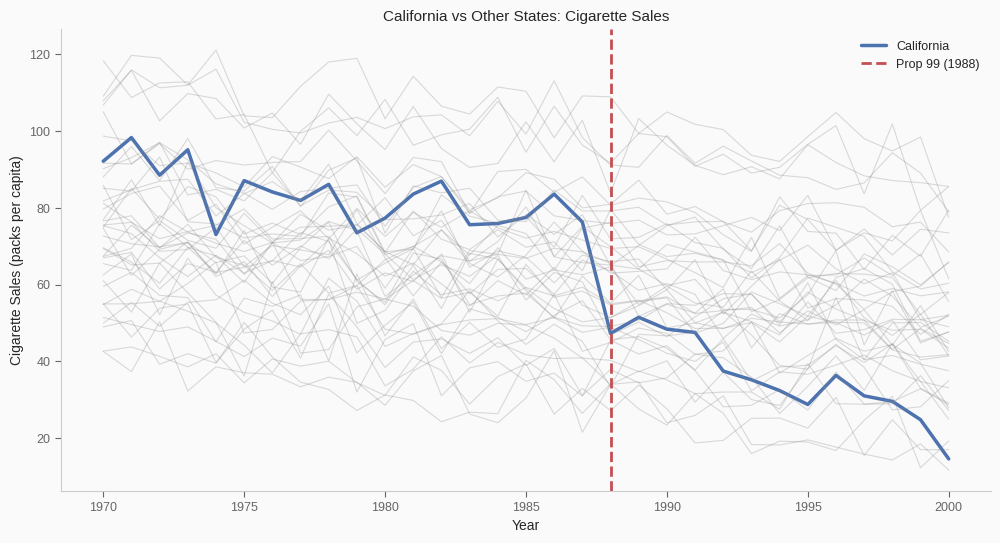

In [3]:
# Visualize raw data
fig, ax = plt.subplots(figsize=(12, 6))

for state in smoking['state'].unique():
    state_data = smoking[smoking['state'] == state]
    if state == 0:  # California
        ax.plot(state_data['year'], state_data['cigsale'], 
                color=COLORS['blue'], linewidth=2.5, label='California')
    else:
        ax.plot(state_data['year'], state_data['cigsale'], 
                color=COLORS['gray'], alpha=0.3, linewidth=0.8)

ax.axvline(x=1988, color=COLORS['red'], linestyle='--', linewidth=2, 
           label='Prop 99 (1988)')
ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales (packs per capita)')
ax.set_title('California vs Other States: Cigarette Sales')
ax.legend()
apply_tufte_style(ax)
plt.show()

### Fit Synthetic California

In [4]:
from scipy.optimize import minimize

def fit_synthetic_control_panel(data, treated_unit, outcome_col, 
                                  unit_col, time_col, pre_periods):
    """
    Fit synthetic control on panel data.
    
    Parameters
    ----------
    data : pd.DataFrame
        Panel data
    treated_unit : int/str
        Treated unit ID
    outcome_col : str
        Outcome variable name
    unit_col : str
        Unit ID column name
    time_col : str
        Time column name
    pre_periods : list
        Pre-treatment time periods
        
    Returns
    -------
    dict
        weights, control_units, pre_rmse
    """
    control_units = [u for u in data[unit_col].unique() if u != treated_unit]
    n_controls = len(control_units)
    
    # Pre-treatment data
    pre_data = data[data[time_col].isin(pre_periods)]
    
    # Treated pre-treatment outcomes
    y_treated = pre_data[pre_data[unit_col] == treated_unit].sort_values(time_col)[outcome_col].values
    
    # Control matrix
    X_control = np.column_stack([
        pre_data[pre_data[unit_col] == u].sort_values(time_col)[outcome_col].values
        for u in control_units
    ])
    
    def objective(w):
        return np.sum((y_treated - X_control @ w)**2)
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n_controls)]
    w0 = np.ones(n_controls) / n_controls
    
    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    pre_rmse = np.sqrt(np.mean((y_treated - X_control @ result.x)**2))
    
    return {
        'weights': result.x,
        'control_units': control_units,
        'pre_rmse': pre_rmse
    }

# Fit SC for California
pre_years = list(range(1970, 1988))
post_years = list(range(1988, 2001))
all_years = list(range(1970, 2001))

sc_california = fit_synthetic_control_panel(
    smoking, treated_unit=0, outcome_col='cigsale',
    unit_col='state', time_col='year', pre_periods=pre_years
)

print("Synthetic California Weights (top donors):")
weight_df = pd.DataFrame({
    'state': sc_california['control_units'],
    'weight': sc_california['weights']
}).sort_values('weight', ascending=False)

for _, row in weight_df[weight_df['weight'] > 0.01].iterrows():
    print(f"  State {int(row['state'])}: {row['weight']:.3f}")

print(f"\nPre-treatment RMSE: {sc_california['pre_rmse']:.2f}")

Synthetic California Weights (top donors):
  State 2: 0.252
  State 6: 0.227
  State 7: 0.149
  State 1: 0.131
  State 15: 0.104
  State 17: 0.056
  State 13: 0.055
  State 20: 0.025

Pre-treatment RMSE: 4.31


In [5]:
def compute_synthetic_series(data, weights, control_units, 
                              outcome_col, unit_col, time_col, periods):
    """
    Compute synthetic control outcome series.
    """
    period_data = data[data[time_col].isin(periods)]
    
    synthetic = []
    for t in sorted(periods):
        t_data = period_data[period_data[time_col] == t]
        y_t = 0
        for u, w in zip(control_units, weights):
            y_u = t_data[t_data[unit_col] == u][outcome_col].values[0]
            y_t += w * y_u
        synthetic.append(y_t)
    
    return np.array(synthetic)

# Compute synthetic California
synthetic_calif = compute_synthetic_series(
    smoking, sc_california['weights'], sc_california['control_units'],
    'cigsale', 'state', 'year', all_years
)

# Actual California
actual_calif = smoking[smoking['state'] == 0].sort_values('year')['cigsale'].values

# Treatment effect (gap)
gap = actual_calif - synthetic_calif

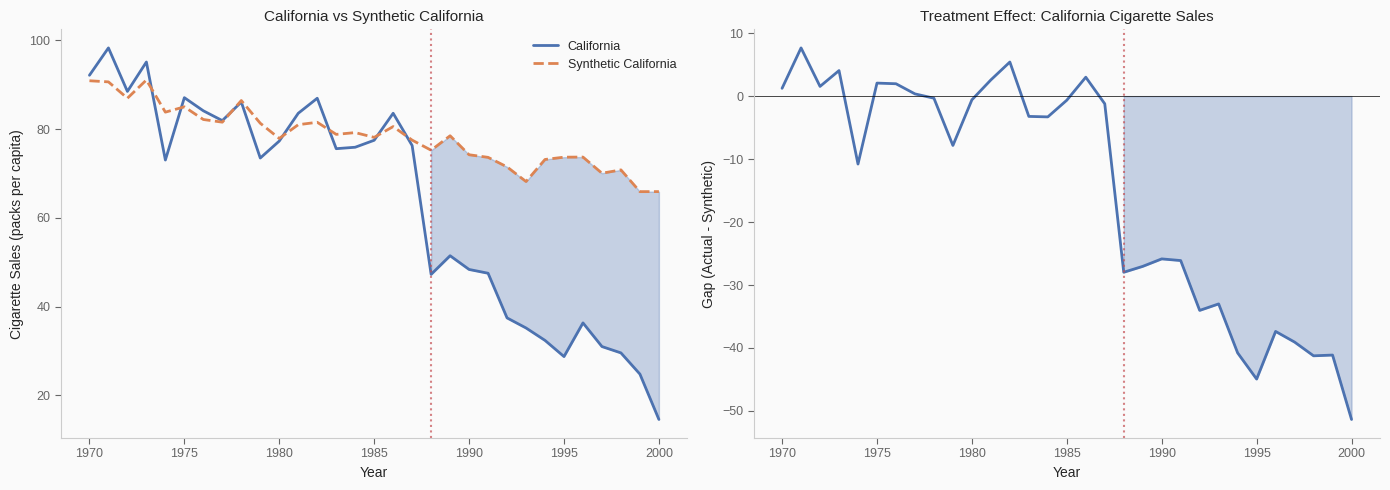


Post-treatment gaps:
  1988: -28.0 packs/capita
  1989: -27.0 packs/capita
  1990: -25.9 packs/capita
  1991: -26.1 packs/capita
  1992: -34.0 packs/capita
  1993: -33.0 packs/capita
  1994: -40.8 packs/capita
  1995: -44.9 packs/capita
  1996: -37.4 packs/capita
  1997: -39.1 packs/capita
  1998: -41.2 packs/capita
  1999: -41.1 packs/capita
  2000: -51.4 packs/capita


In [6]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Outcomes
ax = axes[0]
ax.plot(all_years, actual_calif, color=COLORS['blue'], linewidth=2, label='California')
ax.plot(all_years, synthetic_calif, color=COLORS['orange'], linewidth=2, 
        linestyle='--', label='Synthetic California')
ax.axvline(x=1988, color=COLORS['red'], linestyle=':', alpha=0.7)
ax.fill_between([y for y in all_years if y >= 1988], 
                actual_calif[len(pre_years):], 
                synthetic_calif[len(pre_years):],
                alpha=0.3, color=COLORS['blue'])
ax.set_xlabel('Year')
ax.set_ylabel('Cigarette Sales (packs per capita)')
ax.set_title('California vs Synthetic California')
ax.legend()
apply_tufte_style(ax)

# Panel 2: Gap
ax = axes[1]
ax.plot(all_years, gap, color=COLORS['blue'], linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=1988, color=COLORS['red'], linestyle=':', alpha=0.7)
ax.fill_between([y for y in all_years if y >= 1988], 
                gap[len(pre_years):], alpha=0.3, color=COLORS['blue'])
ax.set_xlabel('Year')
ax.set_ylabel('Gap (Actual - Synthetic)')
ax.set_title('Treatment Effect: California Cigarette Sales')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

print("\nPost-treatment gaps:")
for i, year in enumerate(post_years):
    effect = gap[len(pre_years) + i]
    print(f"  {year}: {effect:.1f} packs/capita")

---

## 4. Implementation {#implementation}

### Per-Period Confidence Intervals

In [7]:
def compute_all_placebo_gaps(data, outcome_col, unit_col, time_col, 
                               pre_periods, post_periods):
    """
    Compute placebo gaps for all units.
    
    Returns
    -------
    dict
        unit -> array of post-treatment gaps
    """
    all_units = data[unit_col].unique()
    all_periods = list(pre_periods) + list(post_periods)
    
    placebo_gaps = {}
    placebo_pre_rmse = {}
    
    for unit in all_units:
        # Fit SC treating this unit as "treated"
        sc_fit = fit_synthetic_control_panel(
            data, unit, outcome_col, unit_col, time_col, pre_periods
        )
        
        # Compute synthetic
        synthetic = compute_synthetic_series(
            data, sc_fit['weights'], sc_fit['control_units'],
            outcome_col, unit_col, time_col, all_periods
        )
        
        # Actual for this unit
        actual = data[data[unit_col] == unit].sort_values(time_col)[outcome_col].values
        
        # Compute gap
        gap = actual - synthetic
        
        # Store post-treatment gaps only
        placebo_gaps[unit] = gap[len(pre_periods):]
        placebo_pre_rmse[unit] = sc_fit['pre_rmse']
    
    return placebo_gaps, placebo_pre_rmse

# Compute all placebo gaps
print("Computing placebo gaps for all states...")
placebo_gaps, placebo_pre_rmse = compute_all_placebo_gaps(
    smoking, 'cigsale', 'state', 'year', pre_years, post_years
)
print(f"Done! Computed gaps for {len(placebo_gaps)} units.")

Computing placebo gaps for all states...


Done! Computed gaps for 39 units.


In [8]:
def per_period_pvalue(treated_gap, all_gaps, period_idx):
    """
    Compute p-value for a specific post-treatment period.
    
    Parameters
    ----------
    treated_gap : float
        Gap for treated unit at this period
    all_gaps : dict
        unit -> array of gaps
    period_idx : int
        Index into post-treatment period
        
    Returns
    -------
    float
        P-value
    """
    # Collect absolute gaps at this period
    abs_gaps = [np.abs(gaps[period_idx]) for gaps in all_gaps.values()]
    
    # P-value: fraction with |gap| >= |treated gap|
    p_value = np.mean(np.array(abs_gaps) >= np.abs(treated_gap))
    
    return p_value


def per_period_ci(treated_unit, all_gaps, period_idx, alpha=0.05, 
                   grid_range=(-100, 50), grid_points=151):
    """
    Compute confidence interval for treatment effect at one period.
    
    Uses grid search to invert the test.
    
    Parameters
    ----------
    treated_unit : int/str
        Treated unit ID
    all_gaps : dict
        unit -> array of gaps
    period_idx : int
        Index into post-treatment period
    alpha : float
        Significance level
    grid_range : tuple
        (min, max) for hypothesized effect
    grid_points : int
        Number of grid points
        
    Returns
    -------
    tuple
        (lower, upper, point_estimate)
    """
    # Point estimate is the observed gap
    point_est = all_gaps[treated_unit][period_idx]
    
    # Grid of hypothesized effects
    theta_grid = np.linspace(grid_range[0], grid_range[1], grid_points)
    
    # For each hypothesized effect, compute p-value
    # Under H0: theta = theta0, the adjusted treated gap is gap - theta0
    p_values = []
    for theta0 in theta_grid:
        # Adjusted treated gap
        adjusted_treated = point_est - theta0
        
        # Compare to placebo gaps (unadjusted, since they have no treatment)
        placebo_abs = [np.abs(gaps[period_idx]) 
                       for u, gaps in all_gaps.items() if u != treated_unit]
        
        # P-value
        p = np.mean(np.array(placebo_abs) >= np.abs(adjusted_treated))
        # Include treated unit in denominator
        p = (1 + np.sum(np.array(placebo_abs) >= np.abs(adjusted_treated))) / len(all_gaps)
        p_values.append(p)
    
    p_values = np.array(p_values)
    
    # CI = values where p-value > alpha
    in_ci = p_values > alpha
    
    if np.any(in_ci):
        lower = theta_grid[in_ci].min()
        upper = theta_grid[in_ci].max()
    else:
        # All rejected - CI is empty (return point estimate bounds)
        lower = upper = point_est
    
    return lower, upper, point_est

# Compute per-period CIs
print("Computing per-period confidence intervals...")
print("-" * 60)

ci_results = []
for i, year in enumerate(post_years):
    lower, upper, point = per_period_ci(
        treated_unit=0, all_gaps=placebo_gaps, period_idx=i,
        alpha=0.10, grid_range=(-80, 30)
    )
    ci_results.append({'year': year, 'lower': lower, 'upper': upper, 'point': point})
    print(f"{year}: {point:6.1f} [{lower:6.1f}, {upper:6.1f}]")

ci_df = pd.DataFrame(ci_results)

Computing per-period confidence intervals...
------------------------------------------------------------
1988:  -28.0 [ -54.3,   -1.5]
1989:  -27.0 [ -53.6,   -0.8]
1990:  -25.9 [ -50.7,   -1.5]
1991:  -26.1 [ -52.9,   -0.1]
1992:  -34.0 [ -58.7,   -8.9]
1993:  -33.0 [ -55.8,  -10.3]
1994:  -40.8 [ -69.0,  -12.5]
1995:  -44.9 [ -67.5,  -22.1]
1996:  -37.4 [ -63.9,  -11.1]
1997:  -39.1 [ -63.9,  -14.0]
1998:  -41.2 [ -66.8,  -16.2]
1999:  -41.1 [ -60.2,  -22.1]
2000:  -51.4 [ -75.6,  -27.2]


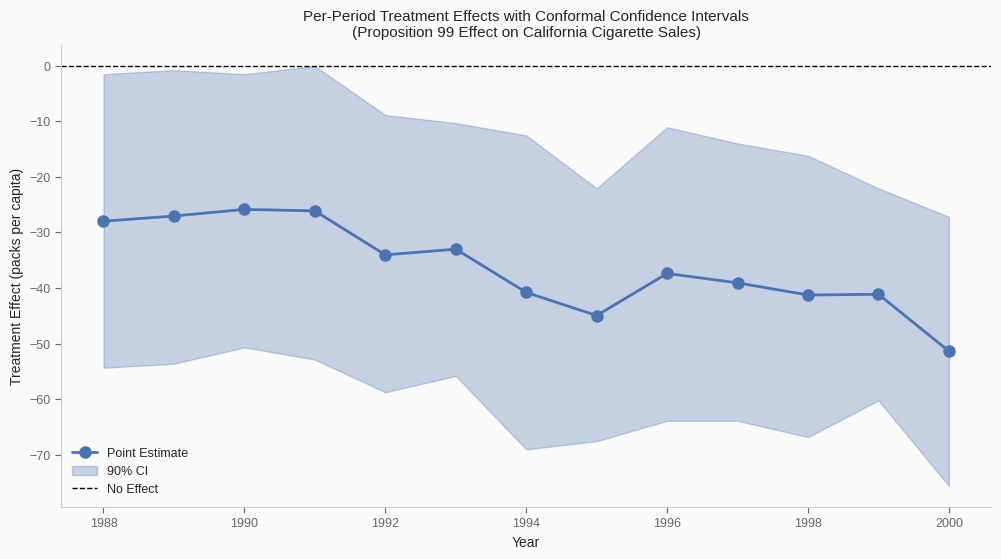

In [9]:
# Visualize per-period CIs
fig, ax = plt.subplots(figsize=(12, 6))

# Plot point estimates
ax.plot(ci_df['year'], ci_df['point'], 'o-', color=COLORS['blue'], 
        linewidth=2, markersize=8, label='Point Estimate')

# Plot CI band
ax.fill_between(ci_df['year'], ci_df['lower'], ci_df['upper'], 
                alpha=0.3, color=COLORS['blue'], label='90% CI')

# Reference line at zero
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, label='No Effect')

ax.set_xlabel('Year')
ax.set_ylabel('Treatment Effect (packs per capita)')
ax.set_title('Per-Period Treatment Effects with Conformal Confidence Intervals\n'
             '(Proposition 99 Effect on California Cigarette Sales)')
ax.legend()
apply_tufte_style(ax)
plt.show()

### Placebo Gap Distribution

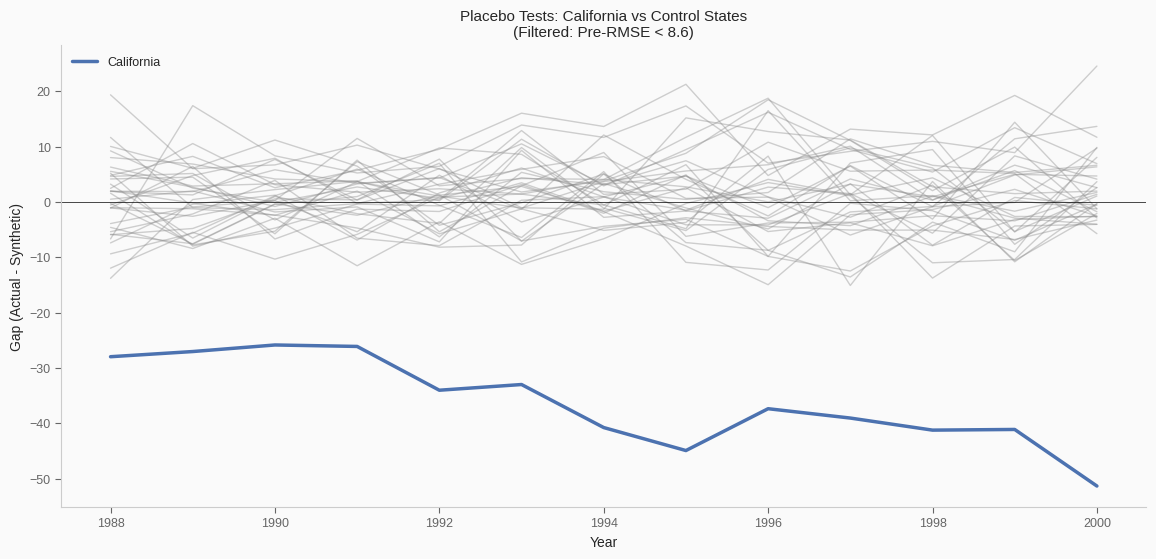

Included: 34 states, Excluded: 5 states (poor pre-fit)


In [10]:
# Visualize all placebo gaps
fig, ax = plt.subplots(figsize=(14, 6))

# Filter by pre-RMSE (keep units with reasonable fit)
treated_pre_rmse = placebo_pre_rmse[0]
rmse_threshold = 2 * treated_pre_rmse

for unit in smoking['state'].unique():
    if placebo_pre_rmse[unit] > rmse_threshold:
        continue  # Skip poorly fitting placebos
    
    gaps = placebo_gaps[unit]
    
    if unit == 0:  # California
        ax.plot(post_years, gaps, color=COLORS['blue'], linewidth=2.5, 
                label='California')
    else:
        ax.plot(post_years, gaps, color=COLORS['gray'], alpha=0.4, linewidth=1)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Gap (Actual - Synthetic)')
ax.set_title('Placebo Tests: California vs Control States\n'
             f'(Filtered: Pre-RMSE < {rmse_threshold:.1f})')
ax.legend()
apply_tufte_style(ax)
plt.show()

# Count included vs excluded
n_included = sum(1 for u, r in placebo_pre_rmse.items() if r <= rmse_threshold)
n_excluded = len(placebo_pre_rmse) - n_included
print(f"Included: {n_included} states, Excluded: {n_excluded} states (poor pre-fit)")

### Aggregate P-Value

In [11]:
def aggregate_pvalue(treated_unit, all_gaps, pre_rmse_dict, 
                      rmse_threshold=None, q=2):
    """
    Compute aggregate conformal p-value using Lq norm.
    
    Parameters
    ----------
    treated_unit : int
        Treated unit ID
    all_gaps : dict
        unit -> array of post-treatment gaps
    pre_rmse_dict : dict
        unit -> pre-treatment RMSE
    rmse_threshold : float or None
        Filter units by pre-RMSE
    q : float
        Order of Lq norm
        
    Returns
    -------
    dict
        p_value, n_included, treated_stat
    """
    # Compute test statistics
    test_stats = {}
    for unit, gaps in all_gaps.items():
        if rmse_threshold and pre_rmse_dict[unit] > rmse_threshold:
            continue
        
        if q == np.inf:
            stat = np.max(np.abs(gaps))
        else:
            stat = np.sum(np.abs(gaps)**q)**(1/q)
        test_stats[unit] = stat
    
    # P-value
    treated_stat = test_stats[treated_unit]
    p_value = np.mean([s >= treated_stat for s in test_stats.values()])
    
    return {
        'p_value': p_value,
        'n_included': len(test_stats),
        'treated_stat': treated_stat,
        'test_stats': test_stats
    }

# Compute aggregate p-values
print("Aggregate P-Values:")
print("-" * 50)

# Without filter
result_all = aggregate_pvalue(0, placebo_gaps, placebo_pre_rmse)
print(f"All states ({result_all['n_included']}): p = {result_all['p_value']:.3f}")

# With filter
result_filtered = aggregate_pvalue(0, placebo_gaps, placebo_pre_rmse, 
                                    rmse_threshold=rmse_threshold)
print(f"Filtered ({result_filtered['n_included']}):   p = {result_filtered['p_value']:.3f}")

Aggregate P-Values:
--------------------------------------------------
All states (39): p = 0.026
Filtered (34):   p = 0.029


```
★ Key Takeaway ────────────────────────────────────────────────
Per-period confidence intervals provide:

1. **Uncertainty quantification** at each time point
2. **Effect dynamics** - how effect grows/shrinks over time
3. **Robustness assessment** - periods where CI includes zero
4. **Policy-relevant bounds** - min/max plausible effects

Prop 99 finding: Significant negative effect on cigarette sales
that grows over time (cumulative policy impact).
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: How do you construct a confidence interval from a p-value function?

<details>
<summary>Solution</summary>

**Test inversion principle**:

A $(1-\alpha)$ confidence interval contains all parameter values that would 
*not be rejected* by a level-$\alpha$ test.

$$CI_{1-\alpha} = \{\theta_0 : p(\theta_0) > \alpha\}$$

**Implementation**:

1. Define a grid of hypothesized values $\theta_0 \in [\theta_{min}, \theta_{max}]$
2. For each $\theta_0$:
   - Adjust data: $\tilde{Y} = Y - \theta_0 \cdot D$
   - Compute test statistic under null
   - Compute p-value via permutation distribution
3. CI bounds = $\{\theta_0 : p(\theta_0) > \alpha\}$

**Properties**:
- Exact coverage: $P(\theta \in CI | H_0) \geq 1 - \alpha$
- May be non-symmetric around point estimate
- Computational cost: O(grid_size × n_units)

</details>

### Q2: What's the difference between pointwise and simultaneous confidence intervals?

<details>
<summary>Solution</summary>

**Pointwise CI**:
- $P(\theta_t \in CI_t) \geq 1 - \alpha$ for each $t$ separately
- 95% CI means: "For any single period, 95% chance of containing true effect"
- **Does NOT guarantee** all periods covered simultaneously

**Simultaneous CI (confidence band)**:
- $P(\theta_t \in CI_t \ \forall t) \geq 1 - \alpha$
- 95% band means: "95% chance that ALL periods are covered"
- Wider than pointwise CIs

**How to get simultaneous bands**:

1. **Bonferroni**: Use $\alpha/T$ for each period
   - Conservative: $CI$ wider than necessary
   - Simple: No dependence structure needed

2. **Maximum-based**: Use distribution of $\max_t |\hat{\theta}_t - \theta_t|$
   - Tighter than Bonferroni
   - Requires resampling

**When to use each**:
- Pointwise: Interpret one period at a time
- Simultaneous: Claim "effect significant in all periods"

</details>

### Q3: How does the number of control units affect CI width?

<details>
<summary>Solution</summary>

**Resolution effect**:

With $J+1$ total units, p-values are multiples of $\frac{1}{J+1}$.

**Impact on CI**:

| Units | Min p-value | CI at α=0.10 |
|-------|------------|---------------|
| 10 | 0.10 | Can be unbounded |
| 20 | 0.05 | Bounded but wide |
| 40 | 0.025 | Tighter bounds |
| 100 | 0.01 | Near-optimal |

**Why**:
- CI includes $\theta_0$ if p-value > α
- With few units, p-value jumps in large steps
- Many $\theta_0$ values map to same p-value

**Practical implication**:
- Few donors → wide, uninformative CIs
- Many donors → tighter CIs (subject to fit quality)
- BUT: More donors may mean worse individual fits

</details>

### Q4: Should you filter units by pre-treatment fit quality?

<details>
<summary>Solution</summary>

**Arguments FOR filtering**:

1. Poor pre-fit → uninformative comparison
   - If SC doesn't match unit $j$ pre-treatment, post-treatment gap is noise

2. More credible inference
   - Compare California to "California-like" placebos
   - Abadie et al. filter: Pre-RMSPE < 2 × treated's Pre-RMSPE

**Arguments AGAINST filtering**:

1. Reduces sample size
   - Fewer placebos → lower resolution → wider CIs

2. Selection bias
   - Units that fit well may be systematically different
   - Could bias inference in unknown direction

3. Post-hoc decision
   - Threshold choice (2x, 3x?) is arbitrary
   - Different thresholds → different conclusions

**Best practice**:
- Report both filtered and unfiltered results
- Pre-register filtering criterion if possible
- Use ratio statistic (post/pre RMSPE) instead of absolute

</details>

### Q5: How do conformal CIs compare to bootstrap CIs for SCM?

<details>
<summary>Solution</summary>

**Bootstrap CIs** (what people sometimes try):

1. Resample time periods or residuals
2. Refit SC on each bootstrap sample
3. Compute percentile CI from bootstrap distribution

**Problems with bootstrap for SCM**:

1. **Unclear what to resample**
   - Units? Time periods? Residuals?
   - Different choices → different answers

2. **Dependent data**
   - Time series structure violated by resampling
   - Block bootstrap helps but doesn't solve

3. **No theoretical justification**
   - Bootstrap consistency requires conditions not verified for SCM

**Conformal CIs**:

| Property | Conformal | Bootstrap |
|----------|-----------|----------|
| Coverage guarantee | Exact | Approximate (if at all) |
| Assumptions | Exchangeability | Many (unclear) |
| Computational | O(J × grid) | O(B × optimization) |
| Finite sample | Valid | May be invalid |

**Recommendation**: Use conformal inference for SCM. Bootstrap is only 
appropriate when you have many treated units (panel methods).

</details>

---

## 6. References {#references}

[^1]: Abadie, A., Diamond, A., & Hainmueller, J. (2010). Synthetic Control Methods 
      for Comparative Case Studies. *Journal of the American Statistical Association*.

[^2]: Chernozhukov, V., Wuthrich, K., & Zhu, Y. (2021). An Exact and Robust Conformal 
      Inference Method for Counterfactual and Synthetic Controls. *JASA*.

[^3]: Firpo, S., & Possebom, V. (2018). Synthetic Control Method: Inference, 
      Sensitivity Analysis and Confidence Sets. *Journal of Causal Inference*.

[^4]: Facure, M. (2022). *Causal Inference for the Brave and True*, Appendix: 
      Conformal Inference for Synthetic Control.